In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import pickle

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split


In [13]:
target_dict={90:'SNIa',67:'SNIa-91bg',
             52:'SNIax',42:'SNII',
             62:'SNIbc',95:'SLSN-I',
             15:'TDE',64:'KN',
             88:'AGN',92:'RRL',
             65:'M-dwarf',16:'EB',
             53:'Mira',6:'Lens-Single',
             994:'PISN', 999:'UNKNOWN',
             992 : 'ILOT', 993:'CaRT',
             995:'Lens-String',1:'Other'}
passband_list = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}

In [27]:
sample = 'Iron/'
curve = 'Half/'
PISN_split = '-2'
model = '_poly'
purpose = 'test'

classification = '_bi'
file = 'FUSED'
additional = '4p/'#
target = 994

threshold=0.5 # Probability threshold above which an object will be classified as the target of interest
              # --> Works only for a binary classfication              

In [14]:
mlmodel= pickle.load(open('../../plasticc/MachineLearningModels/'+sample+curve+additional+'ML_'+PISN_split+model+file+classification+'.sav', 'rb'))

training=pd.read_pickle("../../plasticc/param_table/"+sample+curve+"4p/"+purpose+PISN_split+model+file+".pkl")

if len(mlmodel.classes_)==2:  # Binary case
    training.loc[training['target']!=target,'target']=1
    
print(mlmodel.classes_)
X_train,X_test,y_train,y_test=train_test_split(training.loc[:,0:],training['target'],test_size=0.30,random_state=2)

classes=np.unique(training['target'])

[ 1 88]


In [7]:
if classification == '_bi':
    predic_train=mlmodel.predict_proba(X_train)
    predic_train_target = np.array([1 if x <=threshold else target for x in predic_train[:,1]]) 

else :
    predic_train_target = mlmodel.predict(X_train)

In [8]:
good_prediction_train=y_train==predic_train_target
accuracy_train=good_prediction_train.sum()/len(good_prediction_train)
print('\nThis model has an accuracy of %.2f %% on the training sample'%(accuracy_train*100))


This model has an accuracy of 89.49 % on the training sample


In [9]:
if classification == '_bi':
    predic_test=mlmodel.predict_proba(X_test)
    predic_test_target = np.array([1 if x <=threshold else target for x in predic_test[:,1]]) 

else :
    predic_train_target = mlmodel.predict(X_train)

In [10]:
#Now let us test our model on the testing sample
good_prediction_test=y_test==predic_test_target
accuracy_test=good_prediction_test.sum()/len(good_prediction_test)
print('\nThis model has an accuracy of %.2f %% on the testing sample'%(accuracy_test*100))


This model has an accuracy of 91.59 % on the testing sample


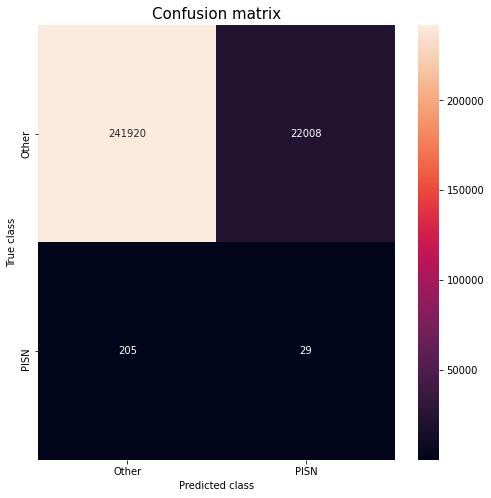

Objects predicted as AGN are really AGN 0.13 % of the time.
AGN are predicted as AGN 12.39 % of the time.


In [28]:
classe_names=[]
for i in range(len(classes)):
    classe_names.append(target_dict.get(classes[i]))

# On calcul la matrice de confusion
conf_matrix = confusion_matrix(y_test, predic_test_target)

#On affiche la matrice de confusion
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, xticklabels=classe_names, yticklabels=classe_names, annot=True, fmt="d");
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title("Confusion matrix",fontsize=15)

plt.show()

pos=1 # Position of the intresting target in the matrix

print('Objects predicted as %s are really %s %.2f %% of the time.'%(str(target_dict.get(target)),str(target_dict.get(target)),100*conf_matrix[pos,pos]/conf_matrix[:,pos].sum()))
print('%s are predicted as %s %.2f %% of the time.'%(str(target_dict.get(target)),str(target_dict.get(target)),100*conf_matrix[pos,pos]/conf_matrix[pos,:].sum()))

In [21]:
d = {'target': y_test, 'proba_target': predic_test[:,1], "proba_other":predic_test[:,0]}
proba_df = pd.DataFrame(data=d)
proba_df = proba_df.sort_values('proba_target',ascending=False)

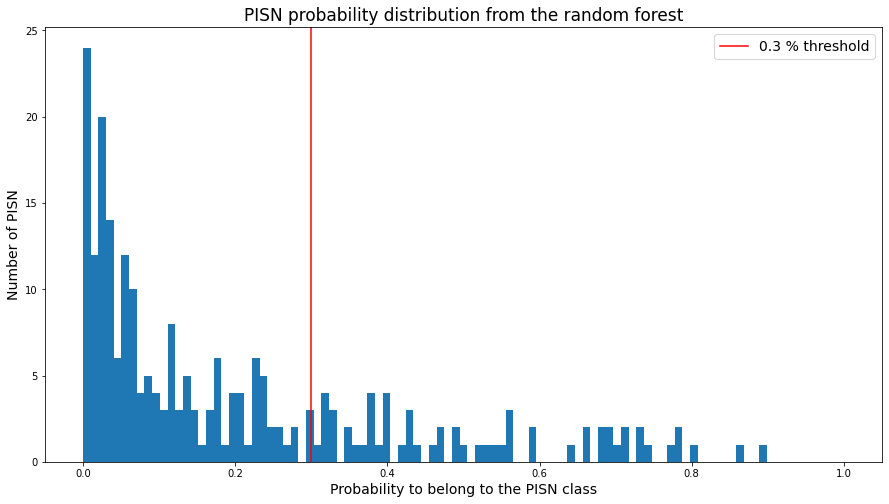

In [26]:
plt.figure(figsize=(15,8))
y = proba_df.loc[proba_df['target']==target,'proba_target']
x = np.linspace(0,1,100)
plt.title('%s probability distribution from the random forest'%str(target_dict.get(target)),fontsize=17)
plt.hist(y,bins=x);
plt.ylabel('Number of %s'%str(target_dict.get(target)),fontsize=14)
plt.xlabel('Probability to belong to the %s class'%str(target_dict.get(target)),fontsize=14)
plt.axvline(x=threshold,color='red',label='%s %% threshold'%threshold)
plt.legend(fontsize=14)
#plt.savefig("hist_proba_pisn.png")